In [15]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio,pytorch_lightning
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

def _IMPORT_(x):
    try:
        exec(x, globals())
    except:
        pass


CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed
pytorch_lightning 1.2.0


In [16]:
###
### Common ###
###

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()
###
### Torch ###
###

_IMPORT_('import torch')
_IMPORT_('import torch.nn as nn')
_IMPORT_('import torch.nn.functional as F')
_IMPORT_('import torch.optim as O')
_IMPORT_('from torchvision import models as M')
_IMPORT_('from torchvision import transforms as T')
_IMPORT_('from torch.utils.data import Dataset, DataLoader')
###
### Viz Model ###
###

_IMPORT_('import  wandb')
_IMPORT_('import hiddenlayer as hl')
_IMPORT_('from graphviz import Digraph, Source')
_IMPORT_('from torchviz import make_dot')
_IMPORT_('from torchsummary import summary')
###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')

# plotly.offline.init_notebook_mode(connected=False)

def show_video(video_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if video_path.startswith('http'):
        data_url = video_path
    else:
        mp4 = open(video_path, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(image_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if image_path.startswith('http'):
        data_url = image_path
    else:
        img = open(image_path, 'rb').read()
        data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))


In [17]:
DATA_PATH = '/raceai/data/media/videos/repnet_mix_test.mp4'
cap = cv2.VideoCapture(DATA_PATH)
print('frames count:', int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if ret is False:
        break
    frames.append(frame)
cap.release()

frames count: 634


In [18]:
show_video(DATA_PATH)

In [19]:
frame1, frame2 = frames[:2]
difference = cv2.absdiff(frame1, frame2)

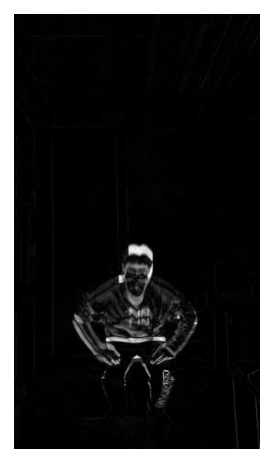

In [90]:
gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt.imshow(gray, cmap='gray');

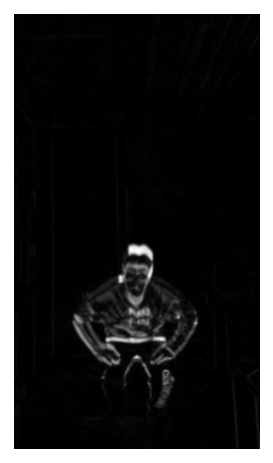

In [91]:
blurred = cv2.GaussianBlur(gray, (5,5), 0)
plt.axis('off')
plt.imshow(blurred, cmap='gray');

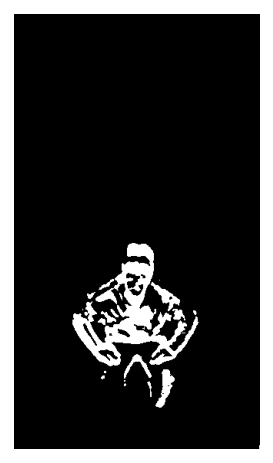

In [92]:
_, threshold = cv2.threshold(blurred, 20, 225, cv2.THRESH_BINARY)
plt.axis('off')
plt.imshow(threshold, cmap='gray');

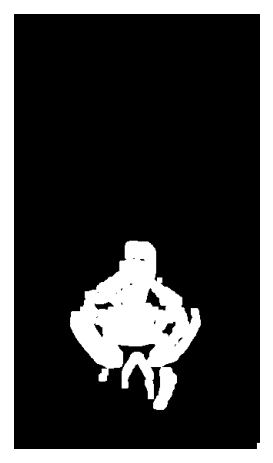

In [93]:
dilated = cv2.dilate(threshold, None, iterations=3)
plt.axis('off')
plt.imshow(dilated, cmap='gray');

In [94]:
contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
if len(contours) > 0:
    print(cv2.contourArea(contours[0]))

18251.5


In [95]:
cv2.drawContours(frame1, contours, 0, (255, 0, 255), thickness = 5);

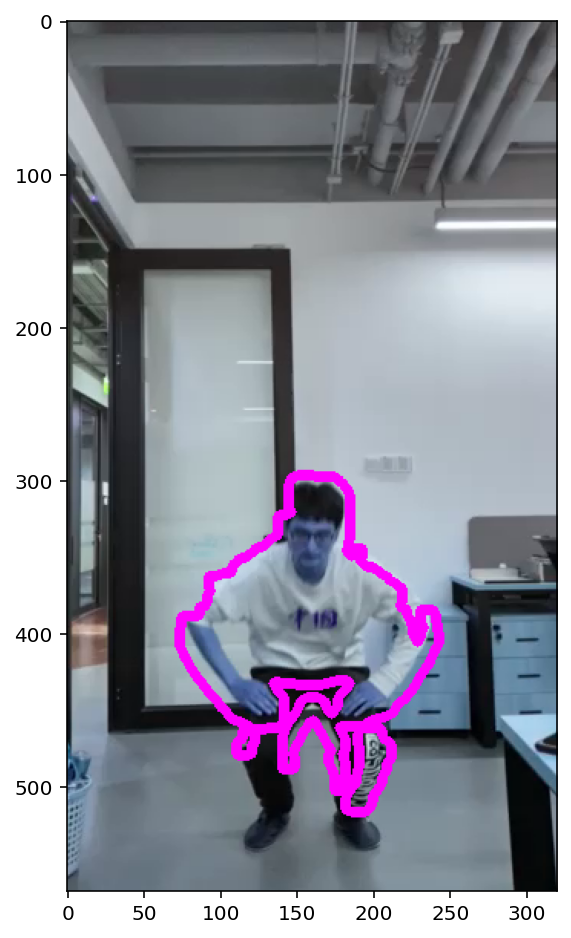

In [96]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.imshow(frame1, cmap='gray')

In [102]:
def get_background(file_path):
    cap = cv2.VideoCapture(file_path)
    # we will randomly select 50 frames for the calculating the median
    frame_indices = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=50)
    # we will store the frames in array
    frames = []
    for idx in frame_indices:
        # set the frame id to read that particular frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        frames.append(frame)
    # calculate the median
    median_frame = np.median(frames, axis=0).astype(np.uint8)
    return median_frame

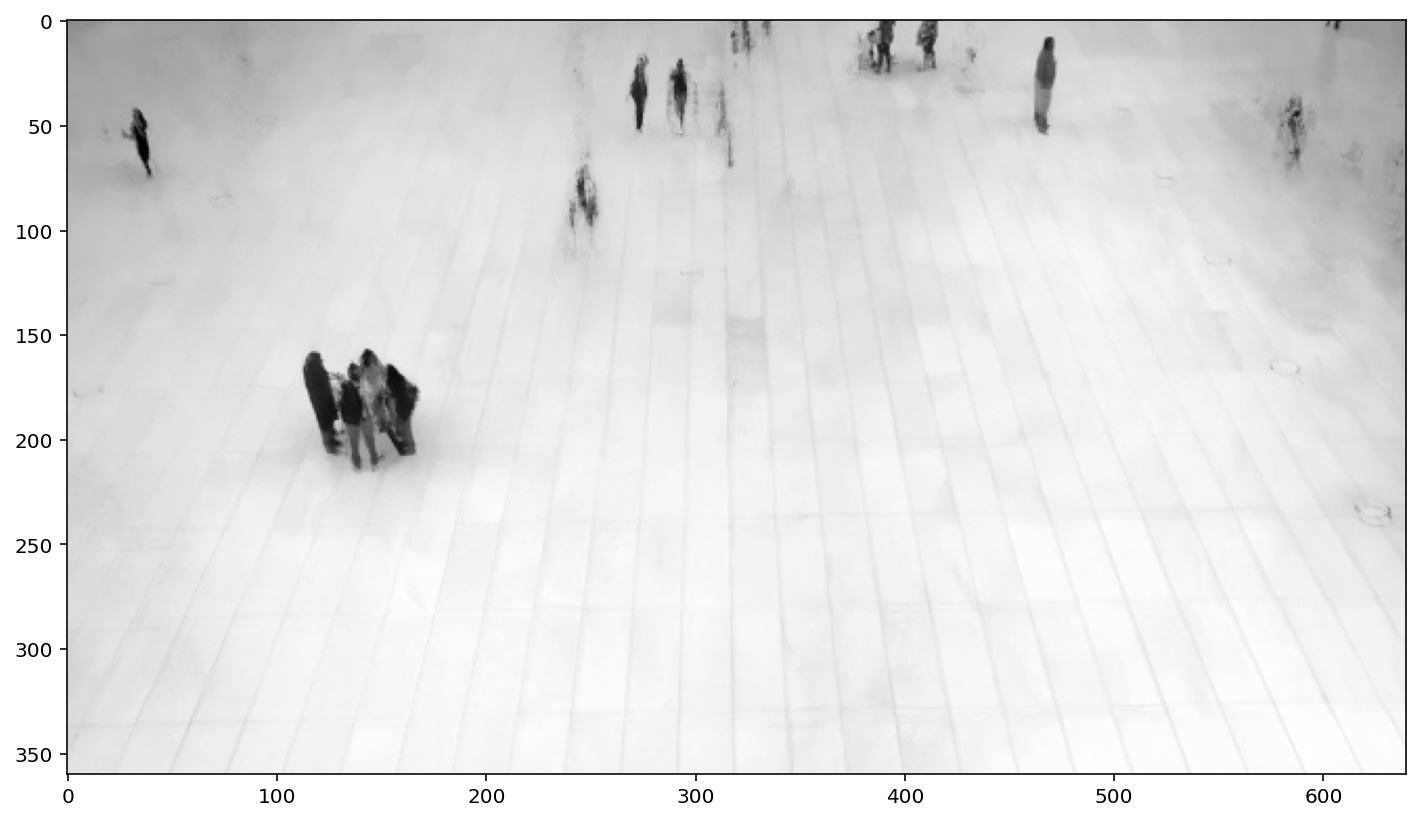

In [103]:
DATA_PATH = '/data/input/video_1.mp4'
background = get_background(DATA_PATH)
# convert the background model to grayscale format
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.imshow(background, cmap='gray');

In [20]:
DATA_PATH = '/raceai/data/media/videos/repnet_mix_test.mp4'

frame_count = 0
consecutive_frame = 4

cap = cv2.VideoCapture(DATA_PATH)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
save_name = f"/data/tmp/test.mp4"
out = cv2.VideoWriter(
    save_name,
    cv2.VideoWriter_fourcc(*'mp4v'), 10, 
    (frame_width, frame_height)
)
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame_count += 1
        orig_frame = frame.copy()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if frame_count % consecutive_frame == 0 or frame_count == 1:
            frame_diff_list = []

        frame_diff = cv2.absdiff(gray, background)
        ret, thres = cv2.threshold(frame_diff, 50, 255, cv2.THRESH_BINARY)
        dilate_frame = cv2.dilate(thres, None, iterations=2)
        frame_diff_list.append(dilate_frame)

        if len(frame_diff_list) == consecutive_frame:
            sum_frames = sum(frame_diff_list)

            contours, hierarchy = cv2.findContours(sum_frames, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for i, cnt in enumerate(contours):
                cv2.drawContours(frame, contours, i, (0, 0, 255), 3)

            for contour in contours:
                if cv2.contourArea(contour) < 500:
                    continue
                    
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(orig_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            out.write(orig_frame)
    else:
        break
cap.release()

NameError: name 'background' is not defined

In [128]:
DATA_PATH = '/raceai/data/media/videos/repnet_mix_test.mp4'

cap = cv2.VideoCapture(DATA_PATH)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

save_name = f"/data/tmp/test-3.mp4"

print(frame_count, frame_width, frame_height, fps)

out = cv2.VideoWriter(
    save_name,
    cv2.VideoWriter_fourcc(*'mp4v'), fps, 
    (frame_width, frame_height)
)

pre_frame = None

while (cap.isOpened()):
    ret, frame = cap.read()
    if ret != True:
        break
    orig_frame = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if pre_frame is None:
        pre_frame = gray
        continue
    frame_diff = cv2.absdiff(gray, pre_frame)
    ret, thres = cv2.threshold(frame_diff, 20, 255, cv2.THRESH_BINARY)
    dilate_frame = cv2.dilate(thres, None, iterations=2)
    
    pre_frame = gray
    contours, hierarchy = cv2.findContours(dilate_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if cv2.contourArea(contour) < 900:
            continue
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(orig_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    out.write(orig_frame)
    
cap.release()

634 320 568 29


In [105]:
show_video(save_name, width=frame_width, height=frame_height)

## References

- https://debuggercafe.com/moving-object-detection-using-frame-differencing-with-opencv/
- https://mlwithsmile.blogspot.com/2019/07/motion-detector-system-in-python.html